In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from scipy import stats, spatial, optimize
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.multivariate.manova import MANOVA
from sklearn.decomposition import PCA
from IPython.core.debugger import set_trace

In [2]:
## LOAD MANUAL AND AUTOMATIC IQMs

code_path = "/data/code/DefacingProject"
data_path = "/data/derivatives/mriqc/RoyalCarpetPlot/DefacingPilotData/shuffled"
manualQCpathCP = "/data/code/DefacingProject/ManualQC/Celine"
manualQCpathOE = "/data/code/DefacingProject/ManualQC/Oscar"

with open(os.path.join(code_path,"DefacingPilotData_blind_dict.json")) as json_file:
    blind_dict = json.load(json_file)
with open(os.path.join(code_path,"DefacingPilotData_pos_dict.json")) as json_file:
    pos_dict = json.load(json_file)

anonym_dict = {'{}'.format(i) : i+1 for i in range(0,9)}
print(anonym_dict)
def get_key(my_dict,val):
    for key, value in my_dict.items():
         if val == value:
             return key

manual_original = np.zeros((10,2))
manual_defaced = np.zeros((10,2))  
iqms_original = np.zeros((10,61))
iqms_defaced = np.zeros((10,61))
for s in range(0,20):
    with open(os.path.join(manualQCpathCP,"_unset__sub-{}_ses-V1_run-1_T1w.json".format(s))) as json_file:
        scoreCP = json.load(json_file)
    with open(os.path.join(manualQCpathOE,"unset__sub-{}_ses-V1_run-1_T1w.json".format(s))) as json_file:
        scoreOE = json.load(json_file)
    with open(os.path.join(data_path, 'sub-{}'.format(s), "ses-V1", "anat","sub-{}_ses-V1_run-1_T1w.json".format(s))) as json_file:
        iqms = json.load(json_file)
        iqms_keys = list(iqms.keys())
        iqms_keys.remove('bids_meta')
        iqms_keys.remove('provenance')
        iqms_keys.remove('size_x')
        iqms_keys.remove('size_y')
        iqms_keys.remove('size_z')
        iqms_keys.remove('spacing_x')
        iqms_keys.remove('spacing_y')
        iqms_keys.remove('spacing_z')
        iqms_keys.remove('summary_bg_p05')

    sub = get_key(blind_dict,s)
    pos = int(get_key(pos_dict,sub[0:8]))

    if "non_deface" in sub:
        # Manual quality rating
        manual_original[pos,0] = scoreCP['rating']
        manual_original[pos,1] = scoreOE['rating']
        # Automatic quality metrics
        for i,key in enumerate(iqms_keys):
            iqms_original[pos,i] = iqms[key]
    elif "pydeface" in sub:
        # Manual quality rating
        manual_defaced[pos,0] = scoreCP['rating']
        manual_defaced[pos,1] = scoreOE['rating']
        # Automatic quality metrics
        for i,key in enumerate(iqms_keys):
            iqms_defaced[pos,i] = iqms[key]
    else:
        raise ValueError("{} is an invalid name".format(sub)) 

{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9}


[3.5 2.5 3.5 2.5 3.5 2.5 3.5 3.  2.  3. ]
[-1.  1. -1. -1. -1. -1. -1.  0.  0.  0.]
[3.  2.  2.5 2.5 3.  2.5 3.  2.5 1.  2. ]
[ 0.  0. -1. -1.  0. -1.  0. -1.  0.  0.]


Text(0.02, 0.5, 'Rating on original image - Rating on defaced image')

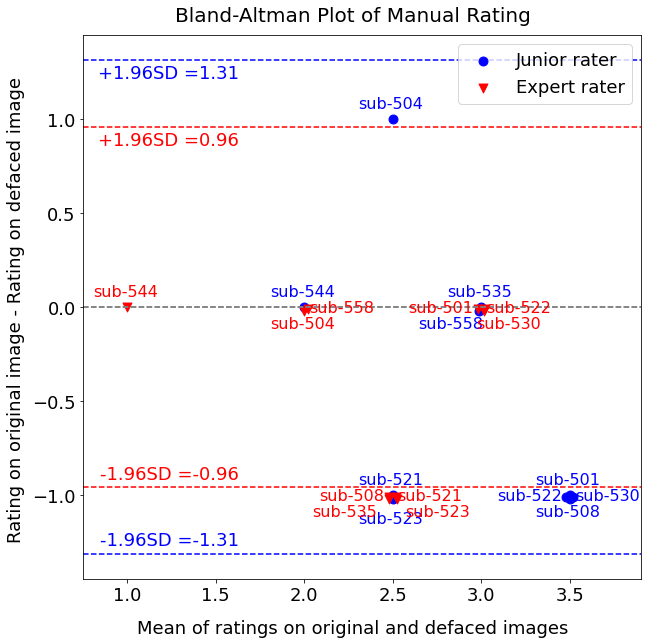

In [3]:
##  BLAND-ALTMAN PLOT

%matplotlib inline
def bland_altman_plot_m(data1,data2,data_label, ax, fontsize, pos_dict=None, color = 'b', marker = 'o', jitter = None):
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = 0 # np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)  # Standard deviation of the difference
    print(mean)
    print(diff)
    for i in range(0,mean.size):
        mean[i]+=jitter[i][0]*0.02
        diff[i]+=jitter[i][1]*0.02
    
    ax.scatter(mean, diff, color=color, label = data_label, marker = marker, s=80)
    ax.axhline(md, color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color=color, linestyle='--')
    ax.axhline(md - 1.96*sd, color=color, linestyle='--')
    ax.tick_params(labelsize=fontsize)
    ax.ticklabel_format(axis='y', style='scientific',scilimits=(-1,1))
    ax.yaxis.offsetText.set_fontsize(fontsize-2)

    if pos_dict is not None:
        trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.28, md + 1.96*sd - 0.12, '+1.96SD ={:.2f}'.format(md+1.96*sd), transform=trans, fontsize=fontsize,
            verticalalignment='bottom', horizontalalignment='right', color=color)
        ax.text(0.28, md - 1.96*sd + 0.12, '-1.96SD ={:.2f}'.format(md-1.96*sd), transform=trans, fontsize=fontsize,
            verticalalignment='top', horizontalalignment='right', color=color)
        for i in range(0, mean.size):
            ax.text(mean[i]-0.01+jitter[i][0]*0.2, diff[i]+0.04+jitter[i][1]*0.15, 'sub-{}'.format(pos_dict[str(i)][-3:]), fontsize=fontsize-2,
                verticalalignment='bottom', horizontalalignment='center', color=color)
            #ax.text(mean[i]-0.01+jitter[i][0]*0.2, diff[i]+0.04+jitter[i][1]*0.15, 'sub-{}'.format(i+1), fontsize=fontsize-2,
                #verticalalignment='bottom', horizontalalignment='center', color=color)

# MANUAL RATING PLOT
fig, ax = plt.subplots(1,sharex=False,sharey=False,figsize=(10,10))
fig.suptitle('Bland-Altman Plot of Manual Rating',fontsize=20, y=0.92)

jitterCP = [(0,0), (0,0), (0,-1), (0,0), (-1,-0.5), (0,-1.2), (1,-0.5), (0,0), (0,0), (-0.75,-1)]
jitterOE = [(-1,-0.5), (0,-1), (-1,-0.5), (1,-0.5), (1,-0.5), (1.2,-1), (0.75,-1), (-1.2,-1), (0,0), (1,-0.5)]
bland_altman_plot_m(manual_original[:,0], manual_defaced[:,0], 'Junior rater', ax, pos_dict=pos_dict, \
                  fontsize = 18, color = 'b', marker = 'o', jitter = jitterCP)
bland_altman_plot_m(manual_original[:,1], manual_defaced[:,1], 'Expert rater', ax, pos_dict=pos_dict, \
                  fontsize = 18, color = 'r', marker = 'v', jitter = jitterOE)
ax.legend(loc='upper right',fontsize = 18)
ax.set_xlim([0.75,3.9])

fig.text(0.5, 0.05, 'Mean of ratings on original and defaced images', fontsize = 18, ha='center')
fig.text(0.02, 0.5, 'Rating on original image - Rating on defaced image', fontsize = 18, va='center', rotation='vertical')

Text(0.1, 0.5, 'IQM on original image - Rating on defaced image')

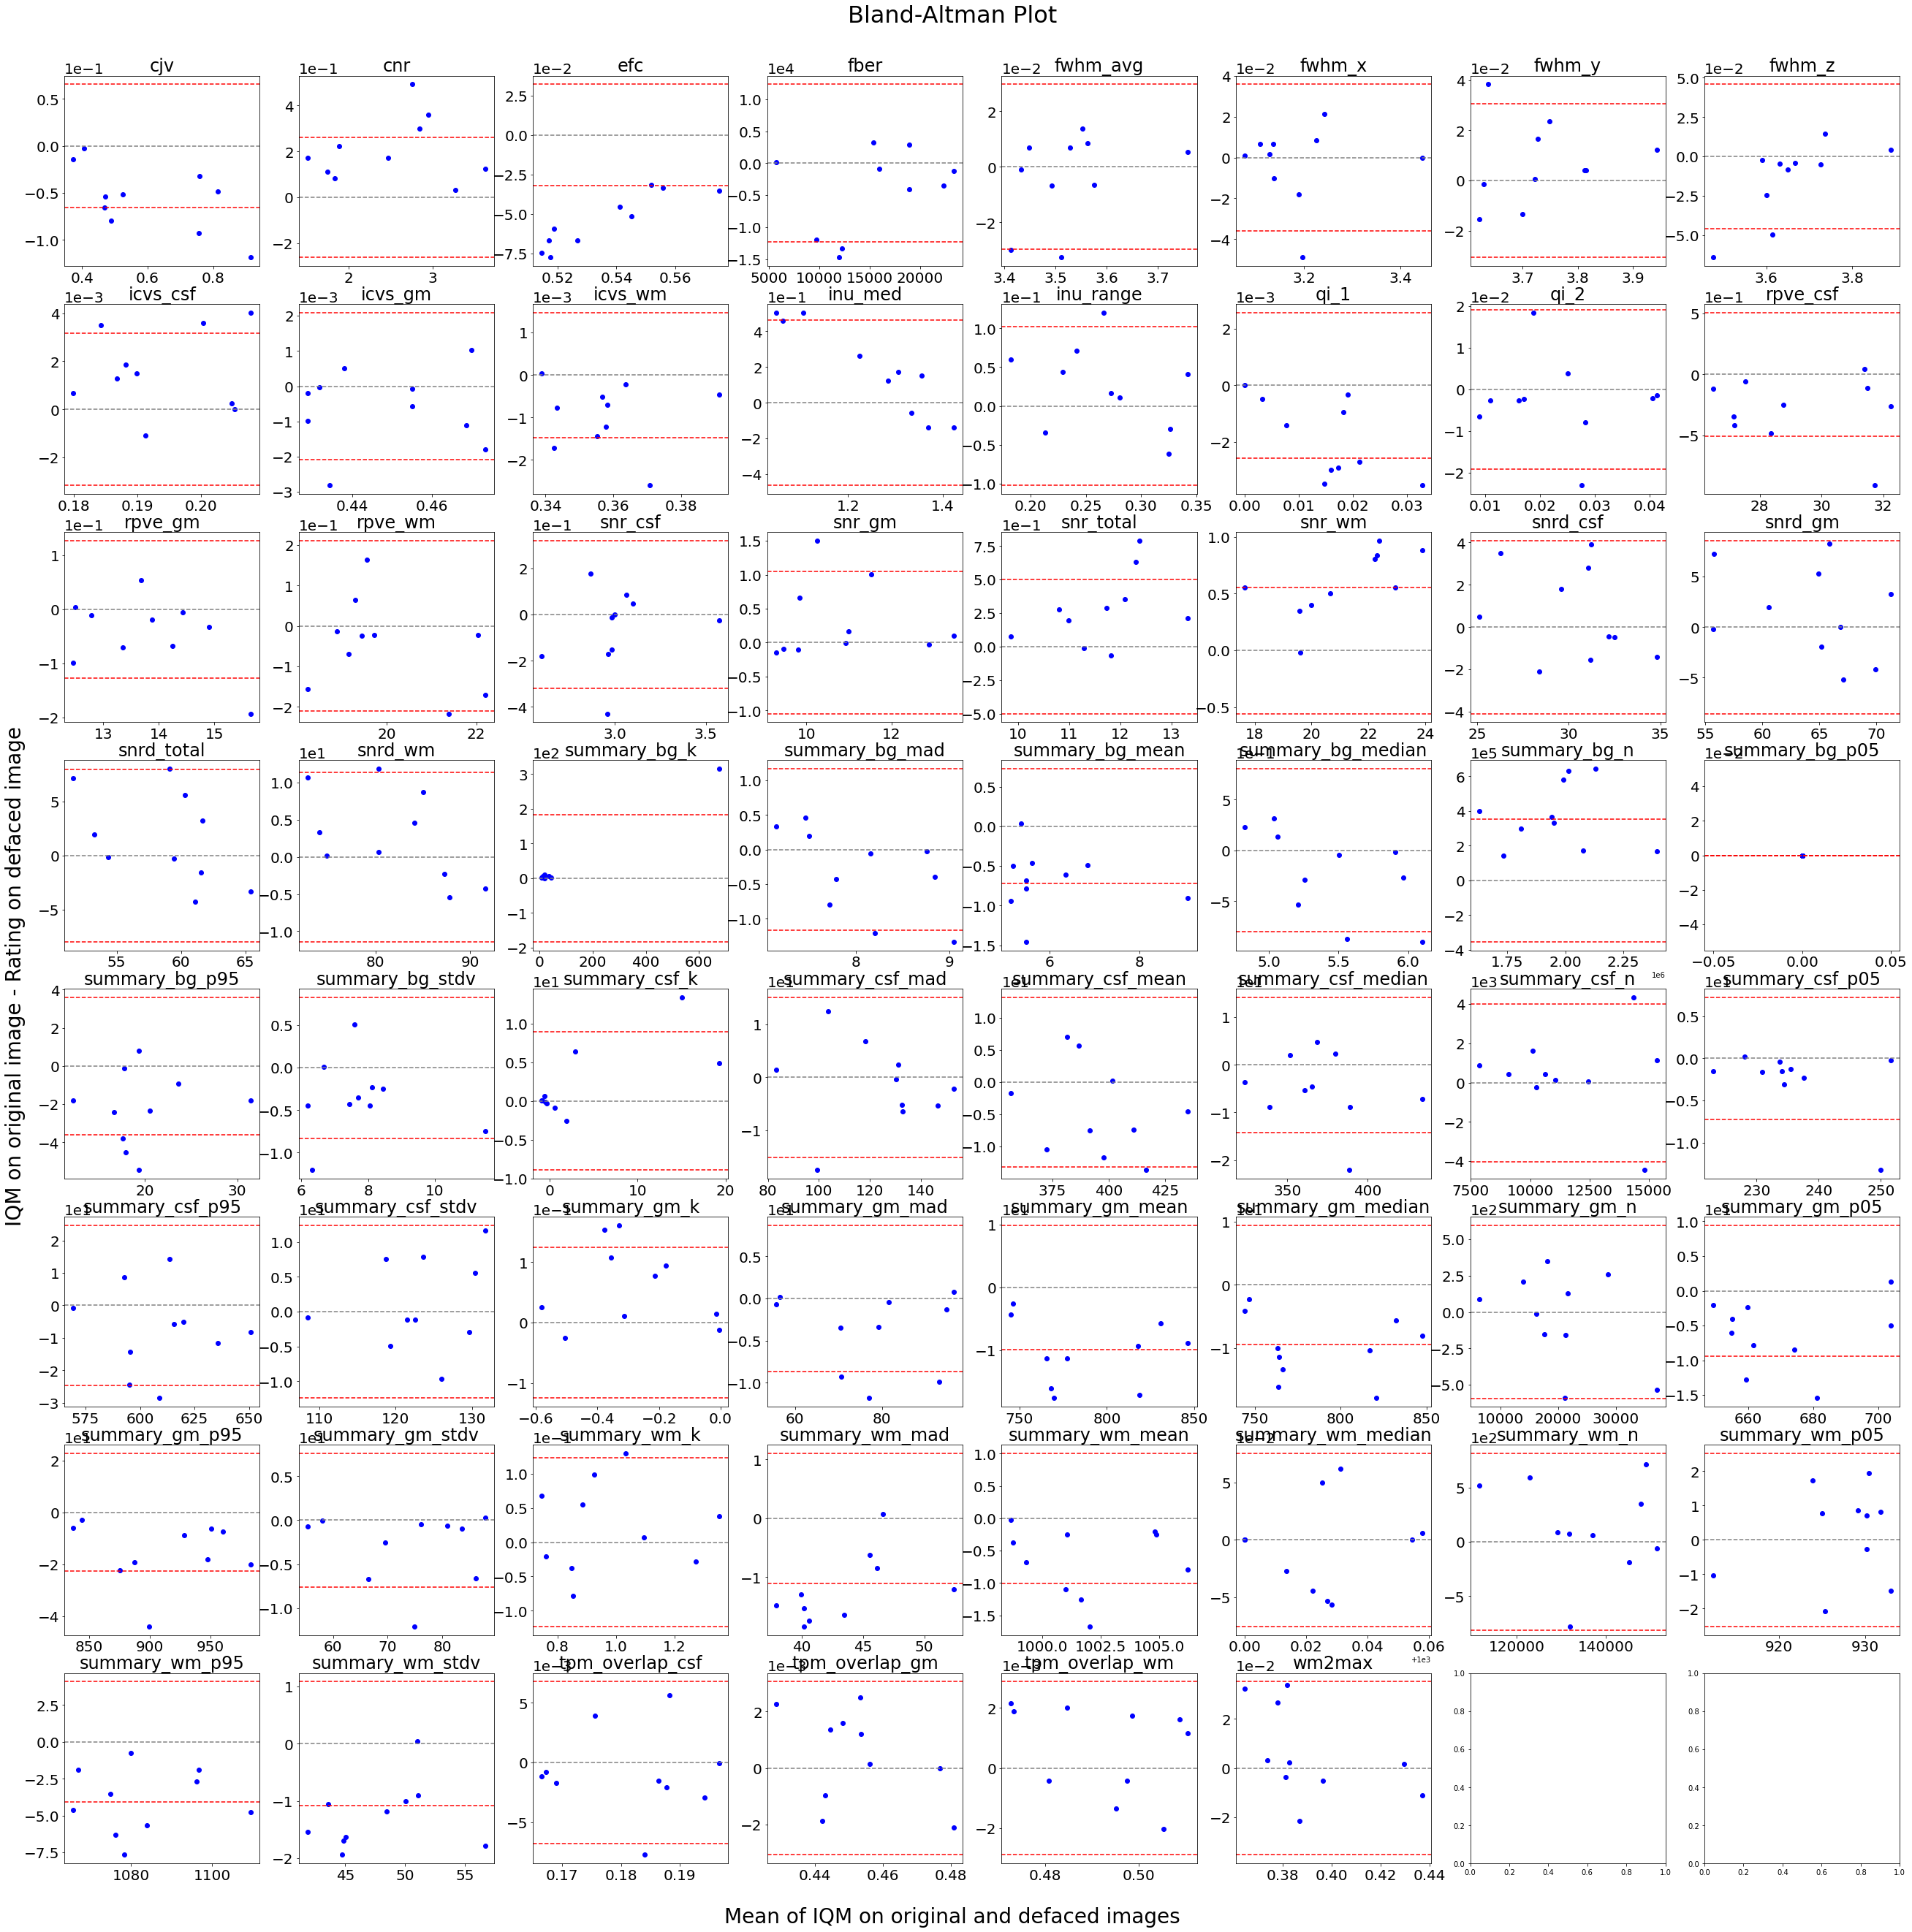

In [80]:
##  BLAND-ALTMAN PLOT

%matplotlib inline
def bland_altman_plot_i(data1,data2,data_label, ax, fontsize, pos_dict=None):
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = 0 # np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)  # Standard deviation of the difference
    
    ax.scatter(mean, diff, color = 'b')
    ax.set_title(data_label,fontsize = fontsize+2)
    ax.axhline(md, color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color='red', linestyle='--')
    ax.axhline(md - 1.96*sd, color='red', linestyle='--')
    ax.tick_params(labelsize=fontsize-2)
    ax.ticklabel_format(axis='y', style='scientific',scilimits=(-1,1))
    ax.yaxis.offsetText.set_fontsize(fontsize-2)

    if pos_dict is not None:
        ax.text(0.98, 0.93, '+1.96SD ={:.2f}'.format(md+sd), transform=ax.transAxes, fontsize=fontsize-2,
            verticalalignment='top', horizontalalignment='right', color='r')
        ax.text(0.98, 0.13, '-1.96SD ={:.2f}'.format(md-sd), transform=ax.transAxes, fontsize=fontsize-2,
            verticalalignment='top', horizontalalignment='right', color='r')
        for i in range(0, mean.size):
            ax.text(mean[i]-0.01, diff[i]+0.03, 'sub-{}'.format(pos_dict[str(i)][-3:]), fontsize=fontsize,
                verticalalignment='bottom', horizontalalignment='center', color='b')
    
# IQMS PLOT
fig, axs = plt.subplots(8,8,sharex=False,sharey=False,figsize=(45,45))
fig.suptitle('Bland-Altman Plot',fontsize=32, y = 0.91)
for i,key in enumerate(iqms_keys):
    bland_altman_plot_i(iqms_original[:,i], iqms_defaced[:,i], key, axs[i//8,i%8], fontsize = 22)

fig.text(0.5, 0.1, 'Mean of IQM on original and defaced images', fontsize = 28, ha='center')
fig.text(0.1, 0.5, 'IQM on original image - Rating on defaced image', fontsize = 28, va='center', rotation='vertical')

In [ ]:
# STATISTICAL TESTS
# Test normality of the data
# TEST VALID ONLY FOR N>20 !!!!!
_,p = stats.normaltest(manual_original, axis = 0)

In [20]:
# t-tests

_,pm = stats.ttest_ind(manual_original, manual_defaced, axis=0)
_,pi = stats.ttest_ind(iqms_original, iqms_defaced, axis=0)
print(pm<0.05)
print(pi<0.05)

rm, pmc, _, _ = multipletests(pm, alpha=0.05, method='bonferroni')
ri, pic, _, _ = multipletests(pi, alpha=0.05, method='bonferroni')
print(rm) 
print(ri)
ind = np.where(ri == True)[0]
print('Difference is significant after bonferroni correction for {}'.format(iqms_keys[ind[0]]))

[False False]
[False False  True False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[False False]
[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
Difference is significant after bonferroni correction for efc


In [45]:
# PCA on original and defaced separately
pca_original = PCA(n_components=None)
pca_original.fit(iqms_original.T)
pca_defaced = PCA(n_components=None)
pca_defaced.fit(iqms_defaced.T)

row_ind, col_ind = optimize.linear_sum_assignment((1-np.corrcoef(pca_original.components_, pca_defaced.components_))[10:,:10])
pca_defaced.components_ = pca_defaced.components_[row_ind,:]

mtxo, mtxd, disparity = spatial.procrustes(pca_original.components_[:3,:],pca_defaced.components_[:3,:])
print(mtxo)
print(disparity)

# MANOVA
# Build dataframe
i_o = np.hstack((pca_original.components_[:3,:].T,np.zeros((10,1))))
i_d = np.hstack((pca_defaced.components_[:3,:].T,np.ones((10,1))))
i_merge = np.vstack((i_o,i_d))
print(i_merge.shape)
iqms_df = pd.DataFrame(i_merge, columns = ['pc1', 'pc2', 'pc3', 'Defaced'])

# Run MANOVA
maov = MANOVA.from_formula('pc1 + pc2 + pc3 ~ Defaced'.format(dep_var), data=iqms_df)

print(maov.mv_test())

[[ 1.93183628e-01  1.37190319e-01 -2.87684491e-02  1.29841851e-01
   2.40640905e-01  1.42390544e-01  9.93941209e-02  4.00263932e-01
  -4.97941212e-04  1.05980842e-01]
 [-1.43143317e-02 -1.37380619e-01  3.14882632e-01 -2.10698415e-01
  -1.83487721e-01 -1.77192227e-01  6.09971233e-02 -1.40856662e-01
  -2.67292882e-01  1.03143310e-01]
 [-1.78869297e-01  1.90299848e-04 -2.86114182e-01  8.08565641e-02
  -5.71531836e-02  3.48016833e-02 -1.60391244e-01 -2.59407270e-01
   2.67790824e-01 -2.09124152e-01]]
2.964852665240823e-31
(20, 4)
                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0130 3.0000 16.0000 406.0585 0.0000
         Pillai's trace  0.9870 3.0000 16.0000 406.0585 0.0000
 Hotelling-Lawley trace 76.1360 3.0000 16.0000

[0.55635191 0.49116241 0.89427749 0.92838518 0.88382807]


"\nprint(pca.components_[1,:])\nfig = plt.figure(figsize=(10,6))\nplt.plot(abs(pca.components_[1,:]),'x')\nplt.yscale('log')\n\npc1 = pca.components_[1,:]\nind = np.where(abs(pca.components_[1,:])>10**-4)[0]\nprint('The significantly different PC is predominantly contributed to by {} with weights of respectively {}'.format(np.array(iqms_keys)[ind], pc1[ind]))"

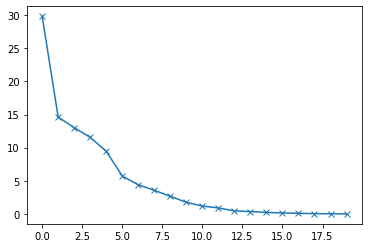

In [6]:
# PCA on original and defaced together
iqms_cat = np.vstack((iqms_original, iqms_defaced))
pca = PCA(n_components=None)
# Z-score so that each IQMs live in the same range of value
iqms_cat_z = stats.zscore(iqms_cat,axis=0)
pca.fit(iqms_cat_z) #n_samples x n_features
basis = pca.components_[:5,:]
projected_iqms = np.matmul(iqms_cat_z,basis.T)
_, p = stats.ttest_ind(projected_iqms[:10,:], projected_iqms[10:,:], axis=0)
print(p)
plt.plot(pca.explained_variance_ratio_ * 100, '-x')
"""
print(pca.components_[1,:])
fig = plt.figure(figsize=(10,6))
plt.plot(abs(pca.components_[1,:]),'x')
plt.yscale('log')

pc1 = pca.components_[1,:]
ind = np.where(abs(pca.components_[1,:])>10**-4)[0]
print('The significantly different PC is predominantly contributed to by {} with weights of respectively {}'.format(np.array(iqms_keys)[ind], pc1[ind]))"""

In [4]:
# MANOVA FULL DATA
# Build dataframe
i_o = np.hstack((iqms_original,np.zeros((10,1))))
i_d = np.hstack((iqms_defaced,np.ones((10,1))))
print(i_o.shape)
print(i_d.shape)
i_merge = np.vstack((i_o,i_d))
print(i_merge.shape)
iqms_df = pd.DataFrame(i_merge, columns = iqms_keys + ['Defaced'])
print(iqms_keys)
iqms_df.drop('summary_bg_p05',axis=1)

# Run MANOVA
dep_var = '' 
for key in iqms_keys:
    dep_var += '{} +'.format(key)
dep_var = dep_var[:-2]

maov = MANOVA.from_formula('{} ~ Defaced'.format(dep_var), data=iqms_df)

print(maov.mv_test())


(10, 63)
(10, 63)
(20, 63)
['cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z', 'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1', 'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm', 'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean', 'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_n', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean', 'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv', 'tpm_overlap_csf', 'tpm_overlap_gm', 'tpm_overlap_wm', 'wm2max']


LinAlgError: Singular matrix

Text(0.5, 0.1, 'Metric value on original image (tick 0) versus metric value on defaced image (tick 1)')

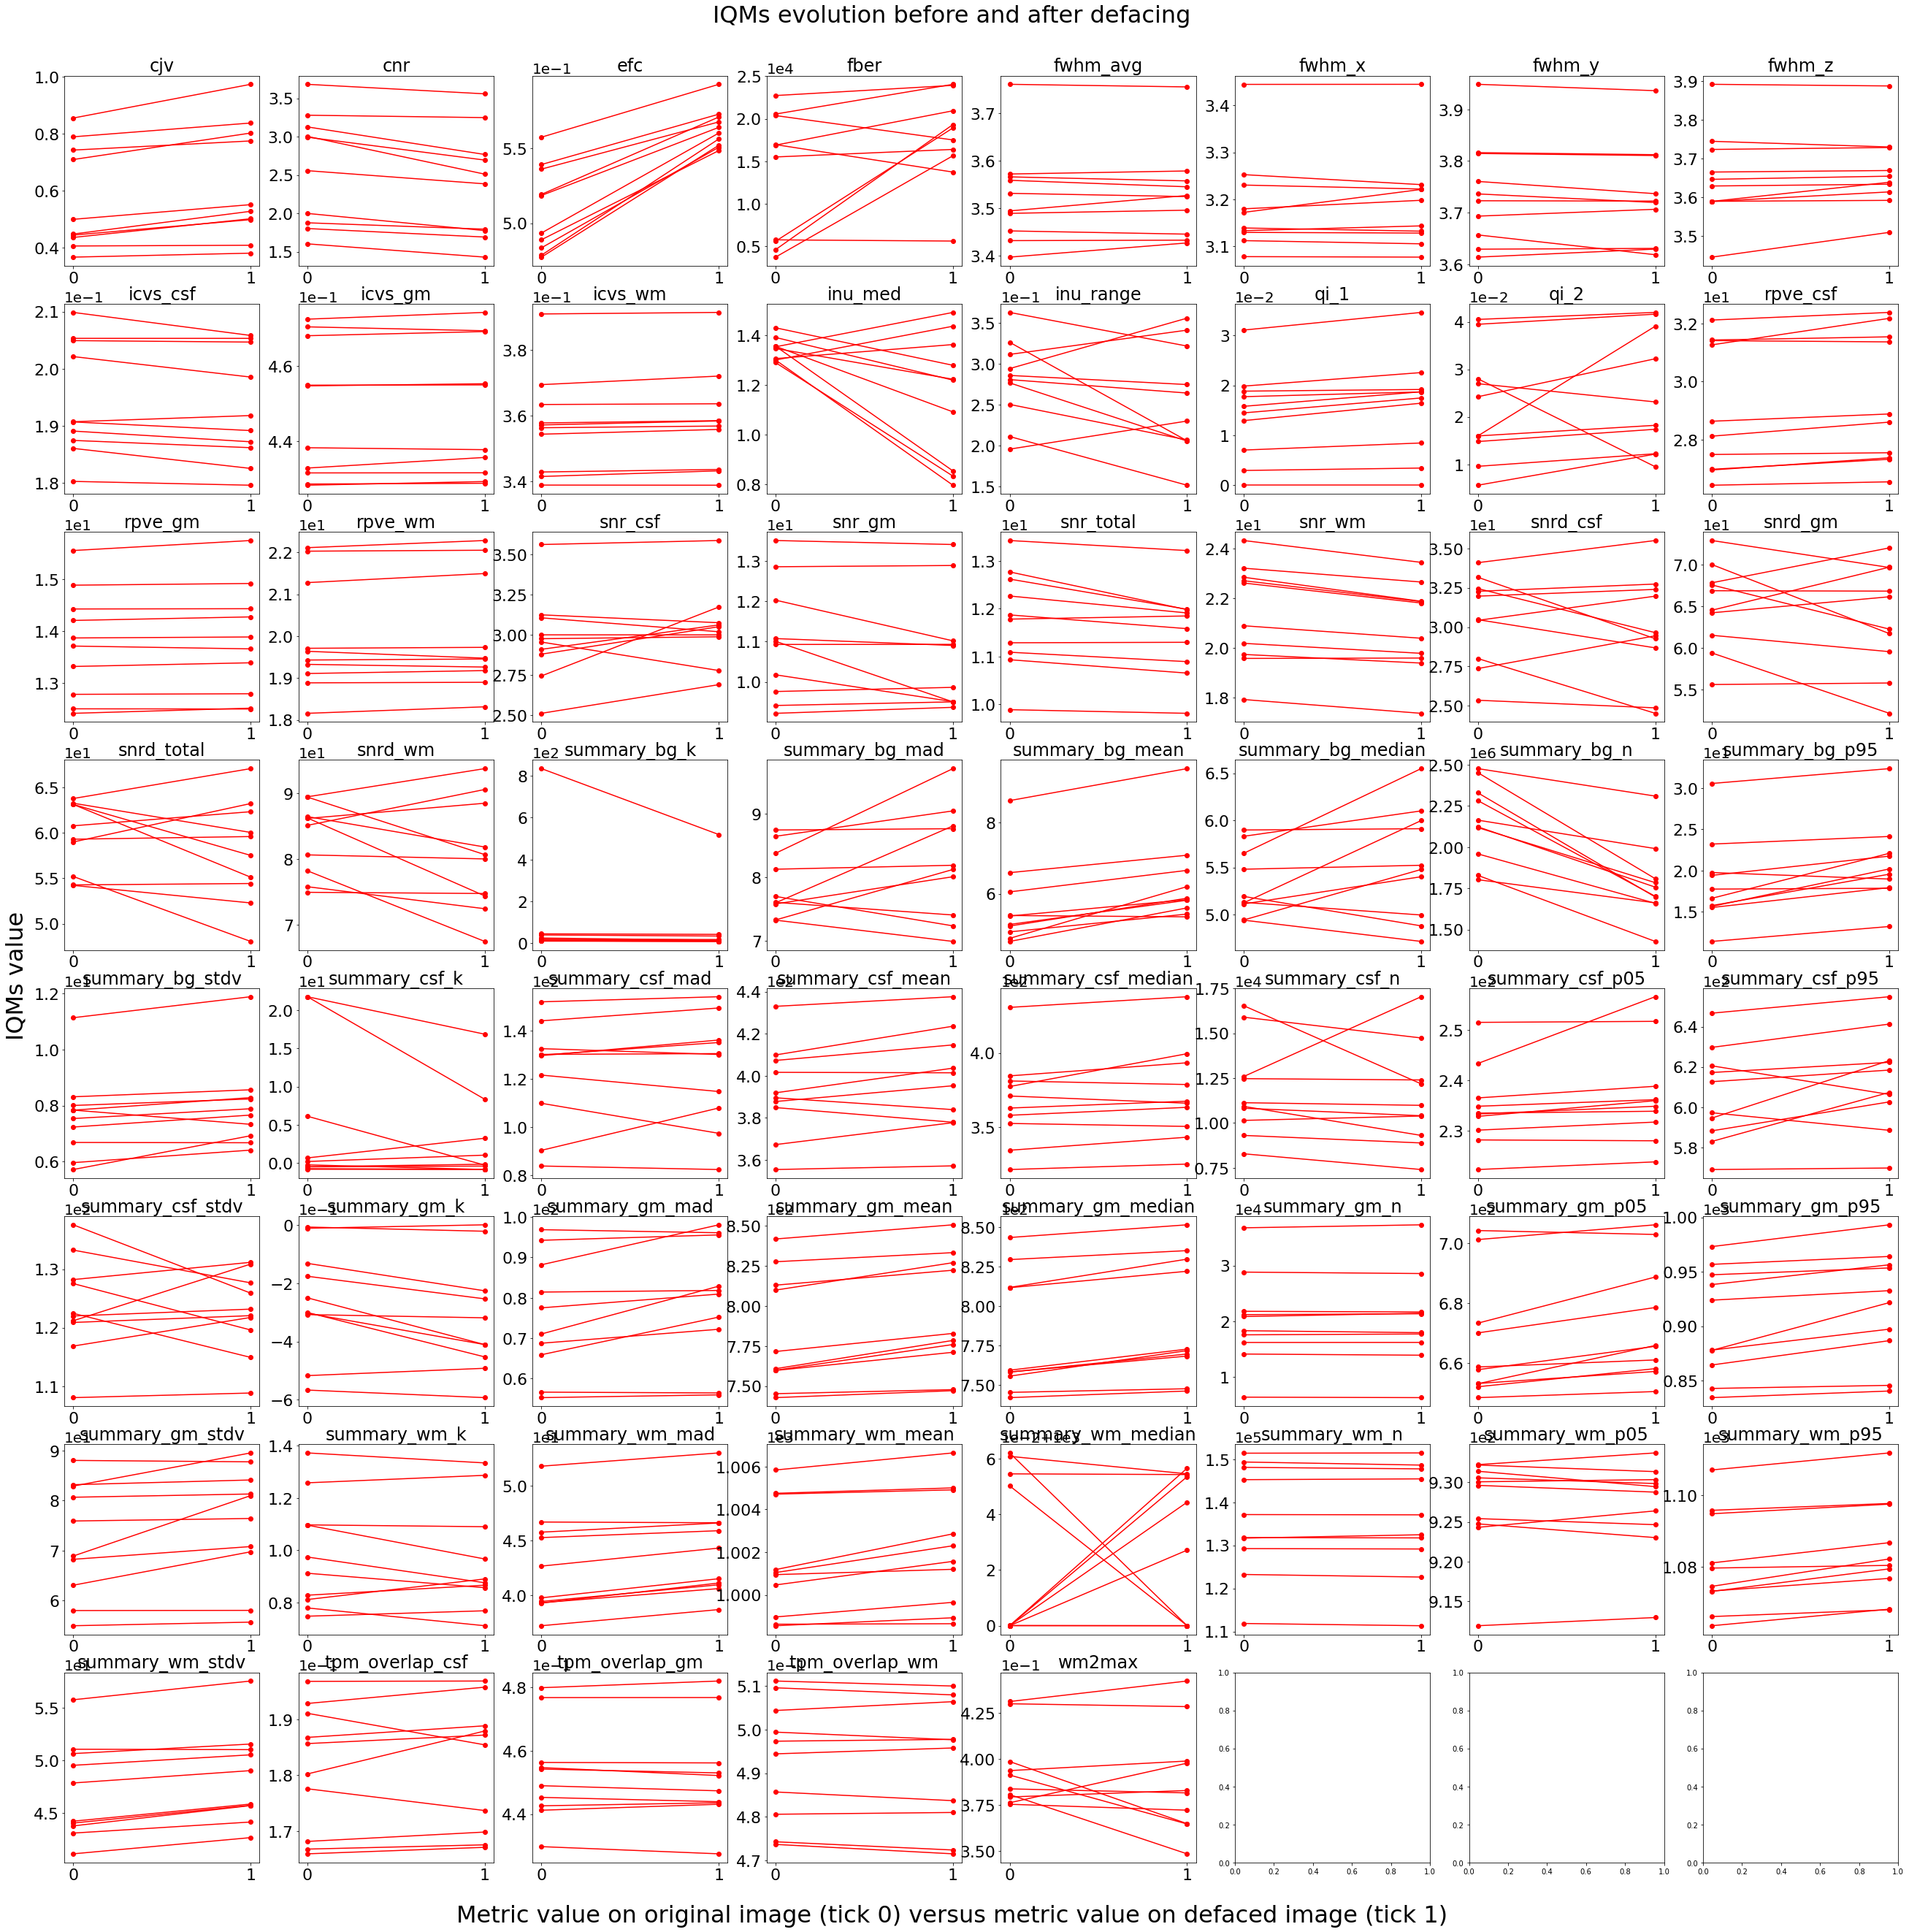

In [5]:
# EVOLUTION PLOT
        
fig, axs = plt.subplots(8,8,sharex=False,sharey=False,figsize=(45,45))
fig.suptitle('IQMs evolution before and after defacing',fontsize=32, y = 0.91)
for i,key in enumerate(iqms_keys):
    ax = axs[i//8,i%8]
    for s in range(0,iqms_original.shape[0]):
        x_values = [0,1]
        y_values = [iqms_original[s,i], iqms_defaced[s,i]]
        ax.plot(x_values, y_values,'-o', color='r')
        ax.set_xticks([0,1])
        ax.set_title(key,fontsize = 24)
        ax.tick_params(labelsize=22)
        ax.ticklabel_format(axis='y', style='scientific',scilimits=(-1,1))
        ax.yaxis.offsetText.set_fontsize(20)
        
fig.text(0.1, 0.5, 'IQMs value', fontsize = 32, va='center', rotation='vertical')
fig.text(0.5, 0.1, 'Metric value on original image (tick 0) versus metric value on defaced image (tick 1)', \
         fontsize = 32, ha='center')